<a href="https://colab.research.google.com/github/Iqbalca/speech_to_text/blob/master/ASR_with_NeMo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'r1.11.0'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

# Introduction to End-To-End Automatic Speech Recognition

This notebook contains the basic concept of Automatic Speech Recognition (ASR), introduced using the [NeMo framework](https://github.com/NVIDIA/NeMo).

## What is ASR?

**Automatic Speech Recognition**, refers to the problem of getting a program to automatically transcribe spoken language (speech-to-text). 

- Our goal is usually to have a model that minimizes the **Word Error Rate (WER)** metric when transcribing speech input.

Traditional speech recognition takes a generative approach that start from

1.  **language model** that focuses on the most likely orderings of words that are generated (e.g. an n-gram model)
2.  **pronunciation model** for each word/phone in that ordering 
3.  **acoustic model** that translates those pronunciations to audio waveforms (e.g. a Gaussian Mixture Model).

With the passage of time, neural nets get advanced andtraditional speech recognition models have been replaced by neural models. That have:

-  better performance 
-  greater potential for generalization. 
   For example, we could replace an n-gram model with a neural language model, and replace a pronunciation table with a neural pronunciation model, and so on.

Now, **end-to-end ASR architectures**: 
- simply take an audio input and give a textual output
- all components of the architecture are trained together  
- language model that can improve our predictions

In [2]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [3]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + 'thorsten-neutral_v03.tgz'):
    an4_url = 'https://zenodo.org/record/5525342/files/thorsten-neutral_v03.tgz?download=1'  # for the original source, please visit https://zenodo.org/record/5525342#.YyCH0KTP1PY
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/thorsten-neutral_v03.tgz'

if not os.path.exists(data_dir + '/thorsten/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/thorsten/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Dataset downloaded at: ./thorsten-neutral_v03.tgz
Converting .sph to .wav...
Finished conversion.
******


In [4]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/thorsten-de_v03/wavs/00025a6fbea659dae6ece011e749aa34.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

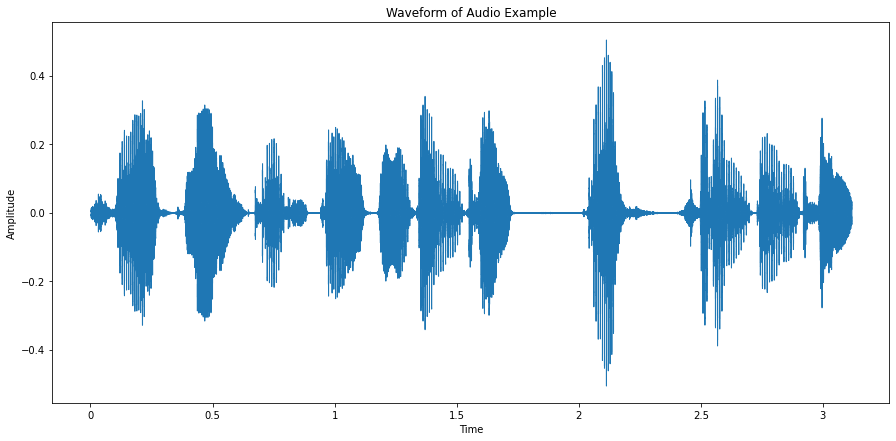

In [5]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio)

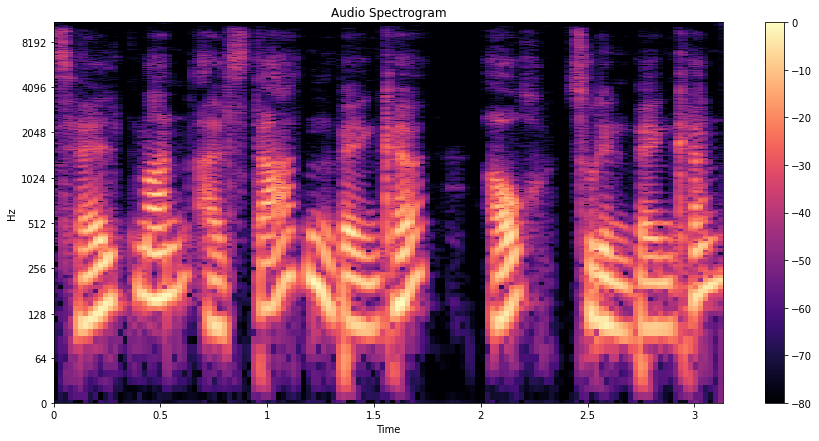

In [6]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

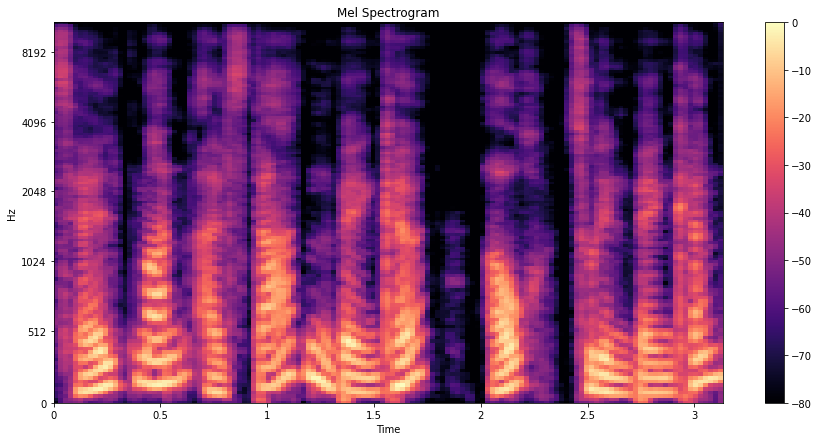

In [7]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

In [8]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

[NeMo W 2022-09-13 14:15:49 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


In [ ]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(model_name="stt_de_conformer_transducer_large")

In [10]:
files = ['./thorsten-de_v03/wavs/00025a6fbea659dae6ece011e749aa34.wav']
for fname, transcription in zip(files, asr_model.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Audio in ./thorsten-de_v03/wavs/00025a6fbea659dae6ece011e749aa34.wav was recognized as: ['hält man als datenbänker auch zu den']


In [17]:
files = ['./thorsten-de_v03/wavs/0014e95911f085b180ea90516cd9615f.wav']
for fname, transcription in zip(files, asr_model.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Audio in ./thorsten-de_v03/wavs/0014e95911f085b180ea90516cd9615f.wav was recognized as: ['es ist eine kleine aber profitable nische']


In [18]:
files = ['./thorsten-de_v03/wavs/00169de3c81f50a7a810efcdac98e695.wav']
for fname, transcription in zip(files, asr_model.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")


Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

Audio in ./thorsten-de_v03/wavs/00169de3c81f50a7a810efcdac98e695.wav was recognized as: ['sich kennzeichen zu merken fällt marcel nicht schwer']
